In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd '/content/drive/My Drive/DGM'
!ls -la

/content/drive/My Drive/DGM
total 553802
-rw------- 1 root root   7158952 Nov 27 13:13 benamara_abdelkader.h5
drwx------ 2 root root      4096 Dec  4 12:00 best_models
-rw------- 1 root root    108465 Nov 27 17:48 Board.h
-rw------- 1 root root       150 Nov 15 20:47 compile.sh
-rw------- 1 root root      1218 Nov 29 15:46 config.py
-rw------- 1 root root      1540 Nov 19 18:21 dataloader.py
-rw------- 1 root root   6298720 Nov 20 11:19 DGV0.h5
-rw------- 1 root root      4344 Nov 20 11:19 DGV0_history
-rw------- 1 root root   7158952 Nov 27 22:25 DGV1.h5
-rw------- 1 root root      2554 Nov 27 22:26 DGV1_history
-rw------- 1 root root   2287592 Nov 29 15:46 DGV2.h5
-rw------- 1 root root     16339 Nov 27 17:48 Game.h
-rw------- 1 root root 542497580 Nov 15 22:41 games.data
-rw------- 1 root root     13825 Nov 27 17:48 golois.cpp
-rw------- 1 root root    236328 Nov 27 17:48 golois.cpython-37m-x86_64-linux-gnu.so
-rw------- 1 root root    236328 Nov 27 17:48 golois.cpython-38-x86_64-li

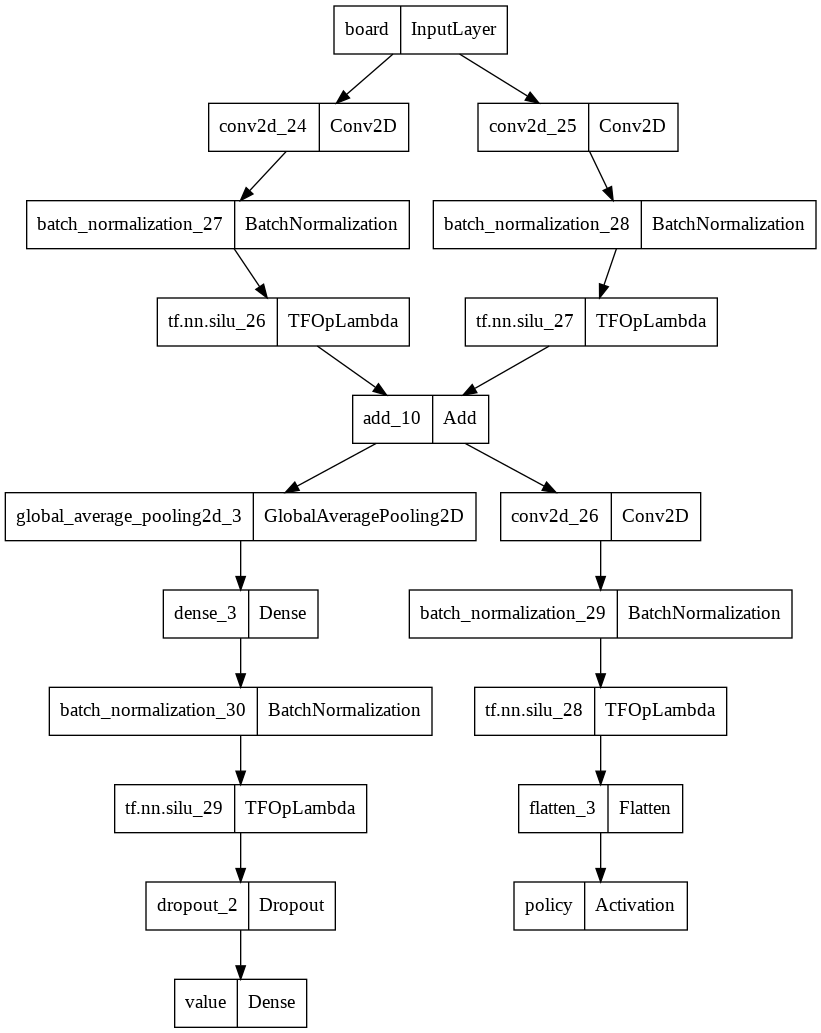

In [ ]:
import os
import tensorflow.nn as nn
from tensorflow.keras import Input,Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers, regularizers,activations
from tensorflow.keras.optimizers import SGD,Adam


n_filters = 64
dropout = 0.3

def activation(x):
    return nn.swish(x)

def input_block(inp,kernel_resize=5,pad='same'):
    # CONV2D + BN + activation 
    x = layers.Conv2D(n_filters, 3, padding=pad)(inp)
    x = layers.BatchNormalization()(x)
    x = activation(x)

    if not kernel_resize:
        return x
    
    # CONV2D (resize) + BN + activation
    x1 = layers.Conv2D(n_filters,kernel_resize, padding=pad)(inp)
    x1 = layers.BatchNormalization()(x1)
    x1 = activation(x1)
    x = layers.add([x, x1])
    
    return x

def output_policy_block(x):
    policy_head = layers.Conv2D(1, 1, padding='same', use_bias=False)(x)
    policy_head = layers.BatchNormalization()(policy_head)
    policy_head = activation(policy_head)
    policy_head = layers.Flatten()(policy_head)
    policy_head = layers.Activation('softmax', name='policy')(policy_head)
    return policy_head
    
def output_value_block(x):
    value_head = layers.GlobalAveragePooling2D()(x)
    value_head = layers.Dense(n_filters)(value_head)
    value_head = layers.BatchNormalization()(value_head)
    value_head = activation(value_head)
    value_head = layers.Dropout(dropout)(value_head)
    value_head = layers.Dense(1, activation='sigmoid', name='value')(value_head)
    return value_head

inp = Input(shape=(19,19,31), name='board')
x = input_block(inp)

policy_head = output_policy_block(x)
value_head = output_value_block(x)

model = Model(inputs=inp, outputs=[policy_head, value_head])


file = os.path.join(os.getcwd(),'model_imgs',f'block.png')
plot_model(model,to_file=file,show_shapes=0)

# Some Learning Rate Scheduling

6.650807746874045e-07


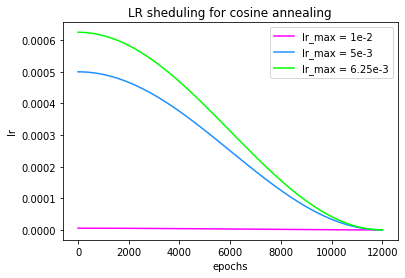

In [ ]:
import matplotlib.pyplot as plt
from math import cos , pi , floor


lr_min = 3e-7
lr_max = 0.00000575
n_epochs = 12_000


def cosine_annealing(epoch,lr_min=lr_min,lr_max=lr_max,n_epochs=n_epochs, n_cycles=1):
    epochs_per_cycle = floor(n_epochs/n_cycles)
    cos_inner = (pi * (epoch % epochs_per_cycle)) / (epochs_per_cycle)
    lr = lr_min + 0.5 * (lr_max - lr_min) * (1 + cos(cos_inner))
    return lr

def cosine_annealing(epoch,lr_min=lr_min,lr_max=lr_max,n_epochs=n_epochs):
    return lr_min + 0.5 * (lr_max - lr_min) * (1 + cos(pi*(epoch/n_epochs)))

print(cosine_annealing(10_000))
lr_max_2 = 0.0005

_epochs = range(1,n_epochs+1)
_lr_1 = list(map(cosine_annealing,_epochs))
_lr_2 = list(map(lambda e : cosine_annealing(e,lr_max=lr_max_2),_epochs))

lr_max_3 = 0.000625
_lr_3 = list(map(lambda e : cosine_annealing(e,lr_max=lr_max_3),_epochs))

plt.plot(_epochs,_lr_1,'magenta',label='lr_max = 1e-2')
plt.plot(_epochs,_lr_2,'dodgerblue',label='lr_max = 5e-3')
plt.plot(_epochs,_lr_3,'lime',label='lr_max = 6.25e-3')

plt.xlabel('epochs')
plt.ylabel('lr')
plt.title('LR sheduling for cosine annealing')
plt.legend()

In [ ]:
import pickle 
import matplotlib.pyplot as plt

LOSS , POLICY_LOSS , VALUE_LOSS , POLICY_ACC , VALUE_MSE = range(5)


def get_metric(d,key):
    return [v[key][0] for _,v in d.items()]

def get_metric_validation(val_hist,metric_idx):
    return [v[metric_idx] for v in val_hist]

def train_plots(epochs , history):
    
    # metrics = ['loss','policy_loss','value_loss','policy_categorical_accuracy','value_mse']
    
    # Losses
    loss = get_metric(history,'loss')
    policy_loss = get_metric(history,'policy_loss')
    value_loss = get_metric(history,'value_loss')

    # Accuracy 
    policy_acc = get_metric(history,'policy_categorical_accuracy')

    # MSE 
    value_mse = get_metric(history,'value_mse')
    


    fig,(ax_loss,ax_acc,ax_mse) = plt.subplots(1,3)
    fig.set_size_inches((16,4))

    # Losses 
    ax_loss.plot(epochs, loss ,'c',label = 'Loss')
    ax_loss.plot(epochs, value_loss, 'g' , label = 'Value Loss')
    ax_loss.plot(epochs, policy_loss ,'r',label = 'Policy Loss')
    ax_loss.set_title('Train Losses History ')
    ax_loss.legend()

    # Accuracy
    ax_acc.plot(epochs, policy_acc , 'r',label = 'Policy Accuracy')
    ax_acc.set_title('Train Policy Accuracy History ')
    ax_acc.legend()

    # MSE
    ax_mse.plot(epochs, value_mse , 'g',label = 'Value MSE')
    ax_mse.set_title('Train Value MSE History ')
    ax_mse.legend()

    fig.show()


def validation_plots(epochs , history):
    
    # metrics = ['loss','policy_loss','value_loss','policy_categorical_accuracy','value_mse']
    
    # Losses
    loss , policy_loss , value_loss = history['loss'], history['policy_loss'],history['value_loss']

    # Accuracy 
    policy_acc = history['policy_acc']

    # MSE 
    value_mse = history['value_mse']
    


    fig,(ax_loss,ax_acc,ax_mse) = plt.subplots(1,3)
    fig.set_size_inches((16,4))

    # Losses 
    ax_loss.plot(epochs, loss ,'c',label = 'Loss')
    ax_loss.plot(epochs, value_loss, 'g' , label = 'Value Loss')
    ax_loss.plot(epochs, policy_loss ,'r',label = 'Policy Loss')
    ax_loss.set_title('Validation Losses History ')
    ax_loss.legend()

    # Accuracy
    ax_acc.plot(epochs, policy_acc , 'r',label = 'Policy Accuracy')
    ax_acc.set_title('Validation Policy Accuracy History ')
    ax_acc.legend()

    # MSE
    ax_mse.plot(epochs, value_mse , 'g',label = 'Value MSE')
    ax_mse.set_title('Validation Value MSE History ')
    ax_mse.legend()

    fig.show()

def get_validation_metrics(val_hist):
    # Get Metrics for Validation
    val_loss = [get_metric_validation(h,LOSS) for h in val_hist]
    val_policy_loss = [get_metric_validation(h,POLICY_LOSS) for h in val_hist]
    val_value_loss = [get_metric_validation(h,VALUE_LOSS) for h in val_hist]
    val_policy_acc = [get_metric_validation(h,POLICY_ACC) for h in val_hist]
    val_value_mse = [get_metric_validation(h,VALUE_MSE) for h in val_hist]

    return {'loss': val_loss , 'policy_loss': val_policy_loss, 'value_loss': val_value_loss,
            'policy_acc': val_policy_acc , 'value_mse': val_value_mse}

def plot_train_val(epochs,train_hist,val_hist,cycle=10):
    val_epochs = [epoch for epoch in epochs if epoch % cycle == 0]
    train_plots(epochs,train_hist)
    validation_plots(val_epochs,val_hist)

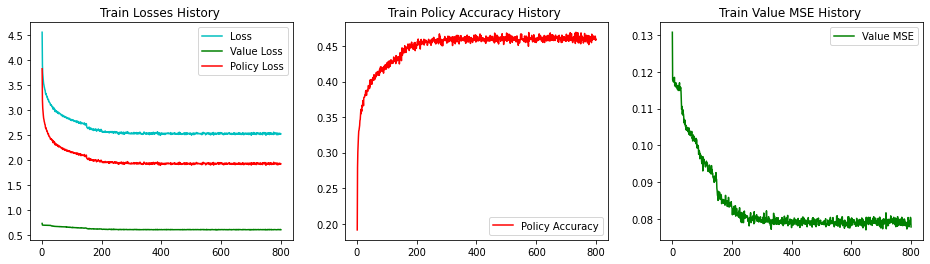

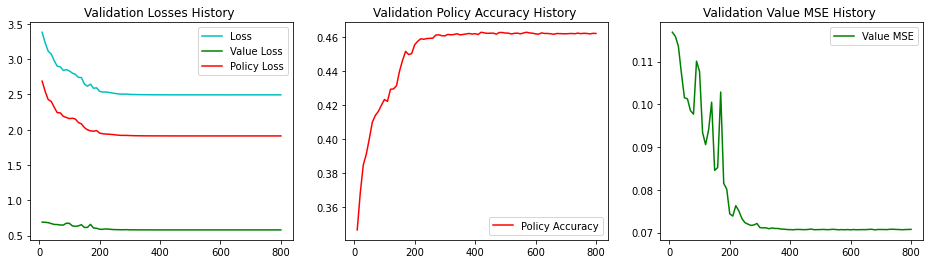

In [ ]:
with open('best_models/DGMV3_history_cosine', 'rb') as f_hist:
    history = pickle.load(f_hist)


epochs = [ k for k in history.keys() if isinstance(k,int)]
train_hist = { k : history[k] for k in epochs}
val_hist = get_validation_metrics(history['val_history'])

plot_train_val(epochs,train_hist,val_hist)



In [ ]:
def train_plots(epochs , histories,styles):
    
    # metrics = ['loss','policy_loss','value_loss','policy_categorical_accuracy','value_mse']
    titles , styles = list(styles.keys()) , list(styles.values())

    # Losses
    loss        = [get_metric(h,'loss') for h in histories]
    policy_loss = [get_metric(h,'policy_loss') for h in histories]
    value_loss  = [get_metric(h,'value_loss') for h in histories]

    # Accuracy 
    policy_acc  = [get_metric(h,'policy_categorical_accuracy') for h in histories]

    # MSE 
    value_mse   = [get_metric(h,'value_mse') for h in histories]
    

    fig,(ax_loss,ax_acc,ax_mse) = plt.subplots(1,3)
    fig.set_size_inches((16,4))

    # Losses 
    for i in range(len(loss)):
      ax_loss.plot(epochs, loss[i] ,styles[i][0],label = f"{titles[i]} loss")
      ax_loss.plot(epochs, value_loss[i], styles[i][1] , label = f"{titles[i]} val_loss")
      ax_loss.plot(epochs, policy_loss[i],styles[i][2],label = f"{titles[i]} pol_loss")
    
    ax_loss.set_title('Train Losses Histories ')
    ax_loss.set_xlabel('epochs')
    ax_loss.set_ylabel('Loss')
    ax_loss.legend()

    # Accuracy
    for i in range(len(policy_acc)):
      ax_acc.plot(epochs, policy_acc[i] , styles[i][0],label = f"{titles[i]} pol_acc")
    
    ax_acc.set_title('Train Policy Accuracy Histories ')
    ax_acc.set_xlabel('epochs')
    ax_acc.set_ylabel('Acc')
    ax_acc.legend()

    # MSE
    for i in range(len(value_mse)):
       ax_mse.plot(epochs, value_mse[i] , styles[i][1],label = f"{titles[i]} val_mse")
    
    ax_mse.set_title('Train Value MSE Histories ')
    ax_mse.set_xlabel('epochs')
    ax_mse.set_ylabel('MSE')
    ax_mse.legend()

    fig.show()

In [ ]:
def validation_plots(epochs , histories, styles,limit=200):
    
    # metrics = ['loss','policy_loss','value_loss','policy_categorical_accuracy','value_mse']
    titles , styles = list(styles.keys()) , list(styles.values())
    
    # Losses
    loss        = [h['loss'][:limit] for h in histories]
    policy_loss = [h['policy_loss'][:limit] for h in histories]
    value_loss  = [h['value_loss'][:limit] for h in histories]


    # Accuracy 
    policy_acc = [h['policy_acc'][:limit] for h in histories]

    # MSE 
    value_mse = [h['value_mse'][:limit] for h in histories]
    
    

    fig,(ax_loss,ax_acc,ax_mse) = plt.subplots(1,3)
    fig.set_size_inches((16,4))

    # Losses 
    for i in range(len(loss)):
      ax_loss.plot(epochs, loss[i] ,styles[i][0],label = f"{titles[i]} loss")
      ax_loss.plot(epochs, value_loss[i], styles[i][1] , label = f"{titles[i]} val_loss")
      ax_loss.plot(epochs, policy_loss[i],styles[i][2],label = f"{titles[i]} pol_loss")

    ax_loss.set_title('Validation Losses History ')
    ax_loss.set_xlabel('epochs')
    ax_loss.set_ylabel('Loss')
    ax_loss.legend()

    # Accuracy
    for i in range(len(policy_acc)):
      ax_acc.plot(epochs, policy_acc[i] , styles[i][0],label = f"{titles[i]} pol_acc")

    ax_acc.set_title('Validation Policy Accuracy History ')
    ax_acc.set_xlabel('epochs')
    ax_acc.set_ylabel('Acc')
    ax_acc.legend()

    # MSE
    for i in range(len(value_mse)):
      ax_mse.plot(epochs, value_mse[i] , styles[i][1],label = f"{titles[i]} val_mse")
    
    
    ax_mse.set_title('Validation Value MSE History ')
    ax_mse.set_xlabel('epochs')
    ax_mse.set_ylabel('MSE')
    ax_mse.legend()

    fig.show()

def get_validation_metrics(val_hist):
    # Get Metrics for Validation
    val_loss        = get_metric_validation(val_hist,LOSS)
    val_policy_loss = get_metric_validation(val_hist,POLICY_LOSS)
    val_value_loss  = get_metric_validation(val_hist,VALUE_LOSS)
    val_policy_acc  = get_metric_validation(val_hist,POLICY_ACC)
    val_value_mse   = get_metric_validation(val_hist,VALUE_MSE)

    return {'loss': val_loss , 'policy_loss': val_policy_loss, 'value_loss': val_value_loss,
            'policy_acc': val_policy_acc , 'value_mse': val_value_mse}

def plot_train_val(epochs,train_hist,val_hist,styles,cycle=10,limit=-1):
    val_epochs = [epoch for epoch in epochs if epoch % cycle == 0]
    train_plots(epochs,train_hist,styles)
    validation_plots(val_epochs,val_hist,styles,limit=limit)

ValueError: ignored

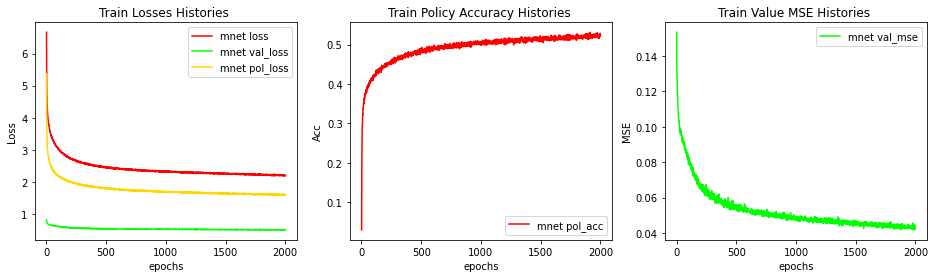

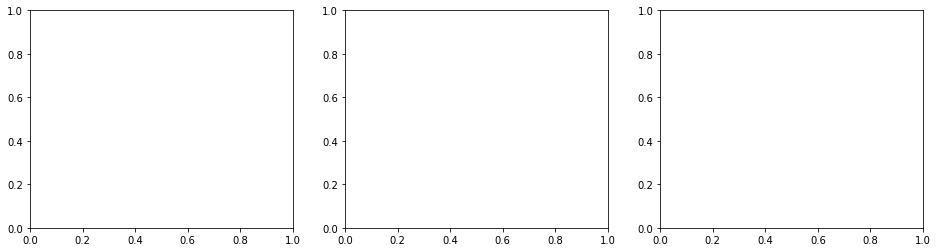

In [ ]:
path = 'best_models/histories/mnas/DGMV9_history_mnas_250_15_625_sw_1_to_5000'

with ExitStack() as stack:
    files = [stack.enter_context(open(path,'rb'))]
    histories = [pickle.load(f) for f in files]

# Plot data (x-axis : epochs , y-axis : histories)
epochs = [ k for k in histories[0].keys() if isinstance(k,int) and k <= 2000]
train_hist = [{ k : history[k] for k in epochs} for history in histories]
val_hist = [get_validation_metrics(history['val_history']) for history in histories]

# The Biggest event ever ! lets plot s#it out ! 
plot_train_val(epochs,train_hist,val_hist,styles,limit=2000)

ValueError: ignored

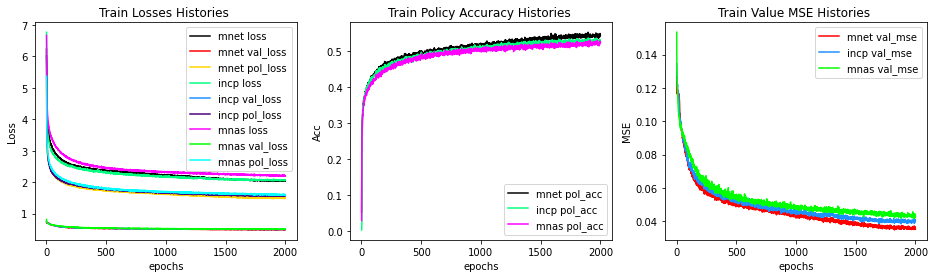

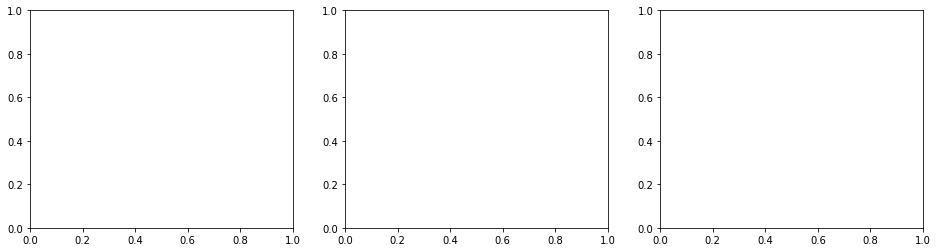

In [ ]:
from contextlib import ExitStack

# First , let's load history files in a clever way 😁

# Here , are histories for models
models_config = {
                  'mnet' : {
                                'path' : 'best_models/DGMV4_history_mnet_se_256_sw_2000', 
                                'style': ['k','r','gold']
                           }
                  ,
                  'incp' : {
                                'path': 'best_models/DGMV8_history_cosine_inception_se_192_sw_2000', 
                                'style': ['springgreen','dodgerblue','indigo']
                           }
                 ,
                 'mnas' :  {
                                'path': 'best_models/histories/mnas/DGMV9_history_mnas_250_15_625_sw_1_to_5000', 
                                'style': ['fuchsia','lime','aqua']
                           }
                }

# Here we manage to load this histories from the pickle binaries
with ExitStack() as stack:
    files = [stack.enter_context(open(fname['path'],'rb')) for fname in models_config.values()]
    histories = [pickle.load(f) for f in files]

# Why not some style ? 🇧🇩 ( always in a clever and a dynamic way ! 😃 )
styles = {name : models_config[name]['style'] for name in models_config.keys()}

# Plot data (x-axis : epochs , y-axis : histories)
epochs = [ k for k in histories[0].keys() if isinstance(k,int) and k <= 2000]
train_hist = [{ k : history[k] for k in epochs} for history in histories]
val_hist = [get_validation_metrics(history['val_history']) for history in histories]

# The Biggest event ever ! lets plot s#it out ! 
plot_train_val(epochs,train_hist,val_hist,styles)

In [ ]:
import os

path = "./best_models/histories/mnet"

# A helper function in order to sort names via epochs order
def rename_hist_name(old_name):
    new_name = old_name.split('_')
    new_name[-1] = f"{int(new_name[-1]):05d}" # rename start epoch 
    new_name[-3] = f"{int(new_name[-3]):05d}" # rename end epoch 
    return "_".join(new_name)

def rename_hist_file(path,old_name=""):
  os.rename(f"{path}/{old_name}",f"{path}/{rename_hist_name(old_name)}")


# Walk into histories and get ordered set of files (names)
filenames = next(os.walk(path), (None, None, []))[2]
for f_name in filenames:
    rename_hist_file(path,f_name)
filenames = next(os.walk(path), (None, None, []))[2]
filenames.sort()

rename_hist_file(path,filenames[0])

hist_path_1 = f"./best_models/histories/mnet/{filenames[0]}"
hist_path_2 = f"./best_models/histories/mnet/{filenames[1]}"

with open(hist_path_1,"rb") as f_hist_1 , open(hist_path_2,"rb") as f_hist_2:
  histories_1 = pickle.load(f_hist_1)
  histories_2 = pickle.load(f_hist_2)

histories = [histories_2]
epochs_1 = [ k for k in histories_1.keys() if isinstance(k,int)]
epochs_2 = [ k for k in histories_2.keys() if isinstance(k,int)]

epochs = epochs_1 + epochs_2
train_hist_1 = [{ k : history[k] for k in epochs_1} for history in histories_1]
train_hist_2 = [{ k : history[k] for k in epochs_2[1:]} for history in histories_2]
histories = 

{621: {'loss': [2.371802568435669],
  'policy_categorical_accuracy': [0.49775999784469604],
  'policy_loss': [1.7206954956054688],
  'value_loss': [0.5233768820762634],
  'value_mse': [0.05060144513845444]},
 622: {'loss': [2.379389762878418],
  'policy_categorical_accuracy': [0.4994400143623352],
  'policy_loss': [1.7268784046173096],
  'value_loss': [0.5246840119361877],
  'value_mse': [0.050031308084726334]},
 623: {'loss': [2.379462242126465],
  'policy_categorical_accuracy': [0.4954400062561035],
  'policy_loss': [1.727830171585083],
  'value_loss': [0.52376788854599],
  'value_mse': [0.05051550269126892]},
 624: {'loss': [2.3710412979125977],
  'policy_categorical_accuracy': [0.49691998958587646],
  'policy_loss': [1.7236580848693848],
  'value_loss': [0.5195180177688599],
  'value_mse': [0.04928543046116829]},
 625: {'loss': [2.375784158706665],
  'policy_categorical_accuracy': [0.49616000056266785],
  'policy_loss': [1.7268903255462646],
  'value_loss': [0.5210620164871216],
  